![](exercise_5_8_1.png)
![](exercise_5_8_2.png)
![](on_policy_algorithm.png)

In [186]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from itertools import product
import random
from matplotlib.animation import FuncAnimation
from math import sin, pi

DEBUG = False

MAP = pd.read_csv('maps/map1.csv', header=None).values
CELL_TYPE_MAP = {
    0: 'WALL',
    1: 'TRACK',
    2: 'GOAL',
    3: 'START',
}

# NB: MAP is row, columns, but we want (x, y) which is the reverse.
MAX_Y = MAP.shape[0] - 1
MAX_X = MAP.shape[1] - 1
MAX_VELOCITY = 5

GAMMA = 0.8
EPSILON = 0.01
MAX_ITERATIONS = 10000

CHEAT_CODES = False


def states():
    """Generates all possible states.
    """
    for x, y, dx, dy in product(
        range(MAX_X + 1), range(MAX_Y + 1), range(0, MAX_VELOCITY + 1), range(0, MAX_VELOCITY + 1)
    ):
        yield (x, y, dx, dy)
        

def cell_type(state):
    """Cell types is given by values of CELL_TYPE_MAP.
    """
    
    x, y, dx, dy = state
    return CELL_TYPE_MAP[MAP[MAX_Y - y, x]]

        
START_STATES = list(set(map(
    lambda state: (state[0], state[1], 0, 0),
    filter(
        lambda state: cell_type(state) == 'START', 
        states()
    )
)))

        
def is_valid_state(state):
    x, y, dx, dy = state
    valid_x = (0 <= x <= MAX_X)
    valid_y = (0 <= y <= MAX_Y)
    valid_dx = (0 <= dx <= MAX_VELOCITY)
    valid_dy = (0 <= dy <= MAX_VELOCITY)
    return valid_x and valid_y and valid_dx and valid_dy


def actions(state):
    """Generate all velocity vectors at a given state.
    """
    assert(is_valid_state(state))
    for ddx in [-1, 0, 1]:
        for ddy in [-1, 0, 1]:
            
            action = (ddx, ddy)
            new_state = move_car(state, action)
            
            if not is_valid_state(new_state):
                continue
                
            if cell_type(new_state) == 'WALL' and CHEAT_CODES:
                continue
             
            yield (ddx, ddy)
            

def move_car(state, action):
    """Move a car using the velocity vector.
    """
    assert(is_valid_state(state))
    x, y, dx, dy = state
    ddx, ddy = action
    
    new_dx = dx + ddx
    new_dy = dy + ddy
    
    new_x = x + new_dx
    new_y = y + new_dy
    
    new_state = (new_x, new_y, new_dx, new_dy)

    return new_state
  

class epsilon_greedy_policy:
    def __init__(self, epsilon):
        self.epsilon = epsilon
        self.policy = {}

    def __setitem__(self, state, action):
        self.policy[state] = action

    def __getitem__(self, state):
        random_state = random.choice(list(actions(state)))
        if random.random() <= self.epsilon:
            return random_state
        return self.policy.get(state, random_state)
    

class epsilon_greedy_policy_sinus:
    def __init__(self, epsilon_rotation, max_epsilon = 0.05):
        
        self.epsilon_rotation = epsilon_rotation
        self.max_epsilon = max(self.epsilon_rotation, max_epsilon)
        
        self.epsilon = 1.0
        self.policy = {}
        self.counter = 1.0
        self.clock_speed = 500
        
    def tick(self):
        self.counter += 1.0
        self.epsilon = (
            self.epsilon_rotation * sin(self.clock_speed * self.counter) + 
            (- ((self.max_epsilon - self.epsilon_rotation) - self.epsilon_rotation) / MAX_ITERATIONS) * self.counter 
            + (self.max_epsilon - self.epsilon_rotation)
        )
        
        
    def __setitem__(self, state, action):
        self.policy[state] = action

    def __getitem__(self, state):
        random_state = random.choice(list(actions(state)))
        if random.random() <= self.epsilon:
            return random_state
        return self.policy.get(state, random_state)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [155]:
def track_progress(iteration, episode_length, epsilon):
    clear_output(wait = True)
    print(
        f'Episode number: {iteration}\n'
        f'Episode length: {episode_length}\n'
        f'Epsilon: {epsilon}'
    )

def on_policy():
    
    action_value = {}
    visit_count = {}
    epsilon_soft_policy = epsilon_greedy_policy_sinus(EPSILON)

    # Used to track progress.
    iteration = 1

    while True:
        
        start_state = random.choice(START_STATES)
        episode = run_episode(epsilon_soft_policy, start_state)
        
        G = 0
        visited_states = []
        
        # Used to track progress.
        episode_length = 1
        
        for state, action, reward in reversed(episode):
            
            G = G + GAMMA * reward
            
            if (state, action,) in visited_states:
                continue
            
            visit_count[(state, action)] = visit_count.get((state, action), 0) + 1

            action_value[(state, action)] = (
                action_value.get((state, action), -10) +
                1 / visit_count[(state, action)] * (G - action_value.get((state, action), -10))
            )
            
            epsilon_soft_policy[state] = best_action(state, action_value)
            
            visited_states.append(
                (state, action,)
            )
            
            episode_length += 1
            
        if 'tick' in dir(epsilon_soft_policy):
            epsilon_soft_policy.tick()
            
        track_progress(iteration, episode_length, epsilon_soft_policy.epsilon)
        iteration += 1
        
        if iteration > MAX_ITERATIONS:
            break
    
    return epsilon_soft_policy, action_value

def run_episode(behaviour_policy, start_state):
    """Used to generate an episode.
    
    Remember:
        state -> action -> reward -> ...
    """
    
    # Initialize episode at start state, the 0 action, and 0 reward.
    state = start_state
    episode = []
    
    while True:
        
        action = behaviour_policy[state]
        
        episode.append(
            (state, action, -1)
        )
        
        state = move_car(state, action)
        
        
        # If no actions are available from state, then reset.
        if len(list(actions(state))) == 0:
            state = random.choice(START_STATES)
            continue
            
        # If state is invalid or a wall, then reset.
        if not is_valid_state(state) or cell_type(state) == 'WALL':
            state = random.choice(START_STATES)
            continue
            
        if cell_type(state) == 'GOAL':
            episode.append(
                (state, (-10, -10), -1)
            )
            break
            
    return episode


def best_action(state, action_value):
    """Returns the best action in a state using the action values.
    """
    state_action_value = [(action_value.get((state, action), -10), action) for action in actions(state)]
    best_action = max(state_action_value)[1]
    
    assert isinstance(best_action, tuple), f'best_action: {best_action}'
    return best_action

# Tests

In [181]:
# Run episodes from all starting points.
for start_state in START_STATES:
    epsilon_soft_policy = epsilon_greedy_policy(EPSILON)
    episode = run_episode(epsilon_soft_policy, start_state)

# For whatever state does shit then make sense.
for state in states():
    
    assert len(list(actions(state))) <= 9, f"state: {state}, action: {action}, new_state: {new_state}."
    assert cell_type(state) in CELL_TYPE_MAP.values(), f"state: {state}, action: {action}, new_state: {new_state}."
    
    for action in actions(state):
        
        new_state = move_car(state, action)
        new_x, new_y, new_dx, new_dy = new_state
        
        assert 0 <= new_x <= MAX_X, f"state: {state}, action: {action}, new_state: {new_state}."
        assert 0 <= new_y <= MAX_Y, f"state: {state}, action: {action}, new_state: {new_state}."
        
        assert 0 <= new_dx <= MAX_VELOCITY, f"state: {state}, action: {action}, new_state: {new_state}."
        assert 0 <= new_dy <= MAX_VELOCITY, f"state: {state}, action: {action}, new_state: {new_state}."
        
        assert cell_type(new_state) in CELL_TYPE_MAP.values(), (
            f"state: {state}, action: {action}, new_state: {new_state}."
        )

# Plotting

In [156]:
def plot_episode(episode):
    reconstructed_episode = reconstruct_last_episode(episode)
    buffer = 1
    ax = plt.axes(xlim=(-buffer, MAX_X + buffer), ylim=(-buffer, MAX_Y + buffer))
    for i in range(len(reconstructed_episode)-1):
        animate(i, reconstructed_episode)
    plot_walls()
    
    
def reconstruct_last_episode(episode):
    """Reconstuct a path.
    """
    res = []
    at_starting_state = False
    for state_action_reward in reversed(episode):
        state, _, _ = state_action_reward
        x, y, dx, dy = state
        res.append(
            [x, y]
        )   
    
    return list(reversed(res))

def plot_walls():
    """Plot the walls in the map.
    """
    for x, y in set(map(
            lambda state: (state[0], state[1]),
            filter(
                lambda state: cell_type(state) == 'WALL',
                list(states())
            )
        )):
        plt.plot([x], [y], marker='o', markersize=3, color="black")


def animate(i, reconstructed_episode):
    """Used to animate the plot.
    """
    [[x1, y1], [x2, y2]] = reconstructed_episode[i:int(i+2)]
    
    plt.plot([x1,x2],[y1,y2], 'r')
    
    if cell_type((x1, y1, 0, 0)) == 'START':
        plt.plot(x1, y1, 'g*')
    
    if cell_type((x2, y2, 0, 0)) == 'GOAL':
        plt.plot(x2, y2, 'r*')

# Run the algorithm and analyze output

In [187]:
epsilon_soft_policy, action_value = on_policy()

Episode number: 10000
Episode length: 43
Epsilon: 0.019635392624634405


In [188]:
assert all(map(lambda state: state in epsilon_soft_policy.policy.keys(), START_STATES)), (
    'All the start states should be in the keys of the policy.'
)

# Race mate

In [189]:
start_state = random.choice(START_STATES)
episode = run_episode(epsilon_soft_policy.policy, start_state)
accumulated_reward = 0
for state, action, reward in episode:
    accumulated_reward += reward
    
    cell_str = cell_type(state)
    state_str = f'state: {state} ' 
    action_str = f'action: {action} '
    reward_str = f'accumulated_reward: {accumulated_reward} '
    print(
         cell_str + ' ' * ( 6 - len(cell_str)) + ': '+
        (state_str + ' ' * (23 - len(state_str))) +
        (action_str + ' ' * (23 - len(action_str))) +
        (reward_str + ' ' * (25 - len(reward_str)))
    )
plt.figure()
plot_episode(episode)

KeyboardInterrupt: 

/home/troels/git/reinforcement_learning_sutton_project/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


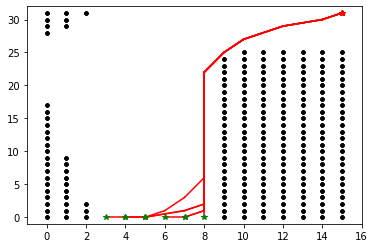

In [184]:
plt.figure()
for start_state in START_STATES:
    episode = run_episode(epsilon_soft_policy.policy, start_state)
    plot_episode(episode)
plt.show()